# RS-Graph Descriptive Statistics

## Data Loading

In [1]:
import colormaps as cmaps
import matplotlib.pyplot as plt
import opinionated  # noqa
import polars as pl
import seaborn as sns

from rs_graph.db.constants import DEV_DATABASE_FILEPATH

# Set seaborn style
plt.style.use("opinionated_rc")
sns.set_palette(
    cmaps.bold[2:]._colors.tolist(),
)

###############################################################################

DB_URI = f"sqlite:///{DEV_DATABASE_FILEPATH}"

###############################################################################

# Helper function to make this easy
def read_table(table: str) -> pl.DataFrame:
    return pl.read_database_uri(f"SELECT * FROM {table}", DB_URI)

/Users/evamaxfield/.local/share/mamba/envs/rs-graph/lib/python3.12/site-packages/opinionated/__init__.py:24: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Now downloading: Roboto Condensed
Added new font as Roboto Condensed Light
Added new font as Roboto Condensed
Added new font as Roboto Condensed
Added new font as Roboto Condensed Black
Now downloading: Montserrat
Added new font as Montserrat Thin Light
Added new font as Montserrat Thin
Added new font as Montserrat Thin
Added new font as Montserrat Thin Black
Now downloading: Source Code Pro
Added new font as Source Code Pro ExtraLight Light
Added new font as Source Code Pro ExtraLight
Added new font as Source Code Pro ExtraLight
Added new font as Source Code Pro ExtraLight Black
Now downloading: Fira Sans
Added new font as Fira Sans Light
Added new font as Fira Sans
Added new font as Fira Sans
Added new font as Fira Sans Black
Now downloading: Fira Sans Condensed
Added new font as Fira Sans Condensed Light
Added new font as Fira Sans Condensed
Added new font as Fira Sans Condensed
Added new font as Fira Sans Condensed Black
Now downloading: IBM Plex Sans
Added new font as IBM Plex San

In [2]:
docs = read_table("document")
repos = read_table("repository")
pairs = read_table("document_repository_link")
locations = read_table("location")
sources = read_table("source")
institutions = read_table("institution")
researchers = read_table("researcher")
authors = read_table("document_contributor")
author_institutions = read_table("document_contributor_institution")
doc_abstracts = read_table("document_abstract")
repo_readmes = read_table("repository_readme")
repo_contributors = read_table("repository_contributor")
researcher_dev_links = read_table("researcher_developer_account_link")
topics = read_table("topic")
doc_topics = read_table("document_topic")

# Drop to unique doc and unique repo in pairs
pairs = pairs.unique(
    subset="document_id", keep="none"
).unique(
    subset="repository_id", keep="none"
)

In [3]:
hydrated_docs = docs.select(
    pl.col("id").alias("document_id"),
    "publication_date",
    "cited_by_count",
    "citation_normalized_percentile",
    "document_type",
    "is_open_access",
    "primary_location_id",
).join(
    locations.select(
        pl.col("id").alias("primary_location_id"),
        "source_id",
    ).join(
        sources.select(
            pl.col("id").alias("source_id"),
            pl.col("name").alias("source_name"),
            pl.col("host_organization_name").alias("source_host_organization"),
            "source_type",
        ),
        on="source_id",
        how="left",
    ),
    on="primary_location_id",
    how="left",
).join(
    doc_abstracts.select(
        "document_id",
        pl.when(pl.col("content").is_null())
            .then(pl.lit(0))
            .otherwise(pl.col("content").str.len_chars())
            .alias("document_abstract_length_chars"),
        pl.when(pl.col("content").is_null())
            .then(pl.lit(0))
            .otherwise(pl.col("content").str.split(" ").list.len())
            .alias("document_abstract_length_words"),
    ),
    on="document_id",
    how="left",
).select(
    "document_id",
    "publication_date",
    "cited_by_count",
    "citation_normalized_percentile",
    "document_type",
    "is_open_access",
    "source_name",
    "source_host_organization",
    "source_type",
    pl.col("document_abstract_length_chars")
        .fill_null(0)
        .alias("document_abstract_length_chars"),
    pl.col("document_abstract_length_words")
        .fill_null(0)
        .alias("document_abstract_length_words"),
)

hydrated_docs

document_id,publication_date,cited_by_count,citation_normalized_percentile,document_type,is_open_access,source_name,source_host_organization,source_type,document_abstract_length_chars,document_abstract_length_words
i64,date,i64,f64,str,bool,str,str,str,u32,u32
1,2015-12-01,43,0.778809,"""article""",true,"""Genome Medicine""","""BioMed Central""","""journal""",0,0
2,2022-10-01,8,0.803035,"""article""",true,"""Alcoholism Clinical and Experi…","""Wiley""","""journal""",1957,267
3,2017-12-08,3,0.697165,"""preprint""",true,"""bioRxiv (Cold Spring Harbor La…","""Cold Spring Harbor Laboratory""","""repository""",1416,207
4,2020-05-18,1,0.476699,"""preprint""",true,"""Wellcome Open Research""","""Wellcome""","""journal""",1220,137
5,2017-09-29,2,0.689392,"""preprint""",true,"""bioRxiv (Cold Spring Harbor La…","""Cold Spring Harbor Laboratory""","""repository""",1289,183
…,…,…,…,…,…,…,…,…,…,…
2856,2022-01-01,1,0.631342,"""preprint""",true,"""arXiv (Cornell University)""","""Cornell University""","""repository""",1798,267
2857,2022-01-01,0,0.0,"""preprint""",true,"""arXiv (Cornell University)""","""Cornell University""","""repository""",1191,168
2858,2018-01-01,0,0.0,"""preprint""",true,"""arXiv (Cornell University)""","""Cornell University""","""repository""",742,106


In [4]:
hydrated_repos = repos.select(
    pl.col("id").alias("repository_id"),
    pl.col("is_fork").alias("repository_is_fork"),
    pl.col("forks_count").alias("repository_forks_count"),
    pl.col("stargazers_count").alias("repository_stargazers_count"),
    pl.col("open_issues_count").alias("repository_open_issues_count"),
    pl.col("commits_count").alias("repository_commits_count"),
    pl.col("size_kb").alias("repository_size_kb"),
    pl.col("topics").alias("repository_topics"),
    pl.col("primary_language").alias("repository_primary_language"),
    pl.col("default_branch").alias("repository_default_branch"),
    pl.col("license").alias("repository_license"),
    pl.col("creation_datetime").alias("repository_creation_datetime"),
    pl.col("last_pushed_datetime").alias("repository_last_pushed_datetime"),
).join(
    repo_readmes.select(
        pl.col("repository_id"),
        pl.when(pl.col("content").is_null())
            .then(pl.lit(0))
            .otherwise(pl.col("content").str.len_chars())
            .alias("repository_readme_length_chars"),
        pl.when(pl.col("content").is_null())
            .then(pl.lit(0))
            .otherwise(pl.col("content").str.split(" ").list.len())
            .alias("repository_readme_length_words"),
    ),
    on="repository_id",
    how="left",
).join(
    repo_contributors.group_by("repository_id").agg(
        pl.col("developer_account_id").count().alias("repository_contributors_count"),
    ),
    on="repository_id",
    how="left",
).with_columns(
    pl.col("repository_readme_length_chars")
        .fill_null(0)
        .alias("repository_readme_length_chars"),
    pl.col("repository_readme_length_words")
        .fill_null(0)
        .alias("repository_readme_length_words"),
    pl.col("repository_contributors_count")
        .fill_null(0)
        .alias("repository_contributors_count"),
).join(
    researcher_dev_links.filter(
        pl.col("predictive_model_confidence") >= 0.97,
    ).sort(
        pl.col("predictive_model_confidence"),
        descending=True,
    ).unique(
        subset="researcher_id",
        keep="first",
    ).select(
        "researcher_id",
        "developer_account_id",
    ).join(
        repo_contributors.select(
            "developer_account_id",
            "repository_id",
        ),
        on="developer_account_id",
        how="left",
    ).group_by(
        "repository_id",
    ).agg(
        pl.col("researcher_id").unique().count().alias("repository_matched_author_devs_count"),
    ),
    on="repository_id",
    how="left",
).with_columns(
    pl.col("repository_matched_author_devs_count")
        .fill_null(0)
        .alias("repository_matched_author_devs_count"),
).with_columns(
    (
        pl.col("repository_matched_author_devs_count")
        / pl.col("repository_contributors_count")
    ).alias("repository_matched_author_devs_pct"),
)

hydrated_repos

repository_id,repository_is_fork,repository_forks_count,repository_stargazers_count,repository_open_issues_count,repository_commits_count,repository_size_kb,repository_topics,repository_primary_language,repository_default_branch,repository_license,repository_creation_datetime,repository_last_pushed_datetime,repository_readme_length_chars,repository_readme_length_words,repository_contributors_count,repository_matched_author_devs_count,repository_matched_author_devs_pct
i64,bool,i64,i64,i64,i64,i64,str,str,str,str,datetime[ns],datetime[ns],u32,u32,u32,u32,f64
1,false,6,17,11,45,5465,null,"""Python""","""master""","""GNU General Public License v3.…",2014-05-05 21:14:57,2018-04-29 16:11:15,3494,383,1,1,1.0
2,false,0,1,0,15,910,null,"""Jupyter Notebook""","""main""","""MIT License""",2021-11-09 04:35:52,2021-11-23 04:14:31,575,72,1,0,0.0
3,false,4,7,1,9,908,null,"""R""","""master""",null,2017-07-10 14:22:18,2018-07-11 12:15:35,13856,2005,1,0,0.0
4,false,0,8,1,129,92494,null,"""Python""","""master""","""MIT License""",2019-04-01 16:16:34,2021-07-12 10:28:10,5848,778,3,2,0.666667
5,false,36,56,21,501,56339,null,"""R""","""master""","""GNU General Public License v3.…",2016-12-13 22:27:50,2024-03-25 19:35:00,10417,1443,8,2,0.25
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2795,false,1,3,1,29,5453,null,"""Python""","""master""",null,2021-07-10 14:29:27,2021-11-18 11:50:32,3313,519,1,1,1.0
2796,false,0,6,0,28,10219,null,"""C++""","""main""","""GNU Lesser General Public Lice…",2022-02-09 14:48:29,2022-08-04 14:57:29,3822,428,2,1,0.5
2797,false,5,37,0,145,12612,null,"""Jupyter Notebook""","""master""","""MIT License""",2017-01-06 18:41:24,2019-04-23 18:43:01,4648,612,3,2,0.666667


In [5]:
hydrated_pairs = pairs.select(
    "document_id",
    "repository_id",
    "dataset_source_id",
).join(
    hydrated_docs,
    on="document_id",
    how="left",
).join(
    hydrated_repos,
    on="repository_id",
    how="left",
)

hydrated_pairs

document_id,repository_id,dataset_source_id,publication_date,cited_by_count,citation_normalized_percentile,document_type,is_open_access,source_name,source_host_organization,source_type,document_abstract_length_chars,document_abstract_length_words,repository_is_fork,repository_forks_count,repository_stargazers_count,repository_open_issues_count,repository_commits_count,repository_size_kb,repository_topics,repository_primary_language,repository_default_branch,repository_license,repository_creation_datetime,repository_last_pushed_datetime,repository_readme_length_chars,repository_readme_length_words,repository_contributors_count,repository_matched_author_devs_count,repository_matched_author_devs_pct
i64,i64,i64,date,i64,f64,str,bool,str,str,str,u32,u32,bool,i64,i64,i64,i64,i64,str,str,str,str,datetime[ns],datetime[ns],u32,u32,u32,u32,f64
1,1,1,2015-12-01,43,0.778809,"""article""",true,"""Genome Medicine""","""BioMed Central""","""journal""",0,0,false,6,17,11,45,5465,null,"""Python""","""master""","""GNU General Public License v3.…",2014-05-05 21:14:57,2018-04-29 16:11:15,3494,383,1,1,1.0
2,2,1,2022-10-01,8,0.803035,"""article""",true,"""Alcoholism Clinical and Experi…","""Wiley""","""journal""",1957,267,false,0,1,0,15,910,null,"""Jupyter Notebook""","""main""","""MIT License""",2021-11-09 04:35:52,2021-11-23 04:14:31,575,72,1,0,0.0
3,3,1,2017-12-08,3,0.697165,"""preprint""",true,"""bioRxiv (Cold Spring Harbor La…","""Cold Spring Harbor Laboratory""","""repository""",1416,207,false,4,7,1,9,908,null,"""R""","""master""",null,2017-07-10 14:22:18,2018-07-11 12:15:35,13856,2005,1,0,0.0
4,4,1,2020-05-18,1,0.476699,"""preprint""",true,"""Wellcome Open Research""","""Wellcome""","""journal""",1220,137,false,0,8,1,129,92494,null,"""Python""","""master""","""MIT License""",2019-04-01 16:16:34,2021-07-12 10:28:10,5848,778,3,2,0.666667
5,5,1,2017-09-29,2,0.689392,"""preprint""",true,"""bioRxiv (Cold Spring Harbor La…","""Cold Spring Harbor Laboratory""","""repository""",1289,183,false,36,56,21,501,56339,null,"""R""","""master""","""GNU General Public License v3.…",2016-12-13 22:27:50,2024-03-25 19:35:00,10417,1443,8,2,0.25
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2856,2795,2,2022-01-01,1,0.631342,"""preprint""",true,"""arXiv (Cornell University)""","""Cornell University""","""repository""",1798,267,false,1,3,1,29,5453,null,"""Python""","""master""",null,2021-07-10 14:29:27,2021-11-18 11:50:32,3313,519,1,1,1.0
2857,2796,2,2022-01-01,0,0.0,"""preprint""",true,"""arXiv (Cornell University)""","""Cornell University""","""repository""",1191,168,false,0,6,0,28,10219,null,"""C++""","""main""","""GNU Lesser General Public Lice…",2022-02-09 14:48:29,2022-08-04 14:57:29,3822,428,2,1,0.5
2858,2797,2,2018-01-01,0,0.0,"""preprint""",true,"""arXiv (Cornell University)""","""Cornell University""","""repository""",742,106,false,5,37,0,145,12612,null,"""Jupyter Notebook""","""master""","""MIT License""",2017-01-06 18:41:24,2019-04-23 18:43:01,4648,612,3,2,0.666667


In [6]:
hydrated_authors = authors.select(
    pl.col("id").alias("document_contributor_id"),
    "researcher_id",
    "document_id",
    pl.col("position").alias("author_position"),
    pl.col("is_corresponding").alias("author_is_corresponding"),
).join(
    author_institutions.select(
        "document_contributor_id",
        pl.col("institution_id").alias("institution_id"),
    ).join(
        institutions.select(
            pl.col("id").alias("institution_id"),
            pl.col("name").alias("institution_name"),
            pl.col("country_code").alias("institution_country_code"),
            "institution_type",
        ),
        on="institution_id",
        how="left",
    ),
    on="document_contributor_id",
    how="left", 
).join(
    researchers.select(
        pl.col("id").alias("researcher_id"),
        pl.col("works_count").alias("author_works_count"),
        pl.col("cited_by_count").alias("author_cited_by_count"),
        pl.col("h_index").alias("author_h_index"),
    ),
    on="researcher_id",
    how="left",
).filter(
    pl.col("document_id").is_in(hydrated_pairs["document_id"].to_list())
)

hydrated_authors

document_contributor_id,researcher_id,document_id,author_position,author_is_corresponding,institution_id,institution_name,institution_country_code,institution_type,author_works_count,author_cited_by_count,author_h_index
i64,i64,i64,str,bool,i64,str,str,str,i64,i64,i64
1,1,1,"""first""",false,1,"""Computational Physics (United …","""US""","""company""",145,3160,25
1,1,1,"""first""",false,2,"""University of Minnesota""","""US""","""funder""",145,3160,25
2,2,1,"""middle""",false,2,"""University of Minnesota""","""US""","""funder""",165,3079,32
3,3,1,"""middle""",false,1,"""Computational Physics (United …","""US""","""company""",114,2883,28
3,3,1,"""middle""",false,2,"""University of Minnesota""","""US""","""funder""",114,2883,28
…,…,…,…,…,…,…,…,…,…,…,…
14540,13512,2859,"""first""",false,129,"""Nanyang Technological Universi…","""SG""","""funder""",32,464,11
14541,13513,2859,"""middle""",false,129,"""Nanyang Technological Universi…","""SG""","""funder""",197,13473,50
14542,13514,2859,"""last""",false,129,"""Nanyang Technological Universi…","""SG""","""funder""",746,25584,77


In [7]:
hydrated_doc_topics = doc_topics.select(
    "document_id",
    "topic_id",
    "score",
).join(
    topics.select(
        pl.col("id").alias("topic_id"),
        pl.col("name").alias("topic_name"),
        pl.col("subfield_name").alias("topic_subfield_name"),
        pl.col("field_name").alias("topic_field_name"),
        pl.col("domain_name").alias("topic_domain_name"),
    ),
    on="topic_id",
    how="left",
).filter(
    pl.col("document_id").is_in(hydrated_pairs["document_id"].to_list())
).select(
    "document_id",
    "topic_name",
    "topic_subfield_name",
    "topic_field_name",
    "topic_domain_name",
    "score",
)

hydrated_doc_topics

document_id,topic_name,topic_subfield_name,topic_field_name,topic_domain_name,score
i64,str,str,str,str,f64
1,"""Cancer Genomics and Diagnostic…","""Cancer Research""","""Biochemistry, Genetics and Mol…","""Life Sciences""",0.9997
1,"""Genomics and Phylogenetic Stud…","""Molecular Biology""","""Biochemistry, Genetics and Mol…","""Life Sciences""",0.9997
1,"""Genomics and Rare Diseases""","""Genetics""","""Biochemistry, Genetics and Mol…","""Life Sciences""",0.9965
2,"""Alcohol Consumption and Health…","""Pathology and Forensic Medicin…","""Medicine""","""Health Sciences""",0.9966
2,"""Forensic Toxicology and Drug A…","""Toxicology""","""Pharmacology, Toxicology and P…","""Life Sciences""",0.9861
…,…,…,…,…,…
2859,"""Domain Adaptation and Few-Shot…","""Artificial Intelligence""","""Computer Science""","""Physical Sciences""",0.9402
2859,"""Anomaly Detection Techniques a…","""Artificial Intelligence""","""Computer Science""","""Physical Sciences""",0.9285
2860,"""Topic Modeling""","""Artificial Intelligence""","""Computer Science""","""Physical Sciences""",0.9933


## Univariate

### Domain Counts

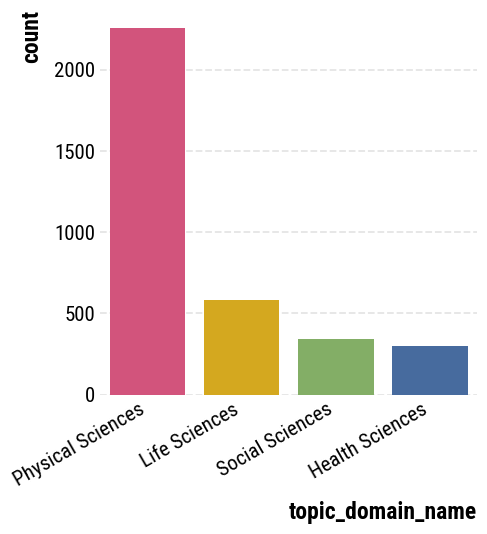

In [8]:
# Drop duplicates on document_id and topic_name
g = sns.catplot(
    hydrated_doc_topics.sort(
        "score",
        descending=True,
    ).unique(
        subset=["document_id", "topic_domain_name"],
        keep="first",
    ).sort(
        "topic_domain_name",
    ).group_by(
        "topic_domain_name",
    ).agg(
        pl.col("document_id").count().alias("count"),
    ).sort(
        "count",
        descending=True,
    ),
    x="topic_domain_name",
    y="count",
    kind="bar",
    hue="topic_domain_name",
    hue_order=hydrated_doc_topics["topic_domain_name"].unique().sort().to_list(),
)
g.figure.autofmt_xdate()

### Field Counts

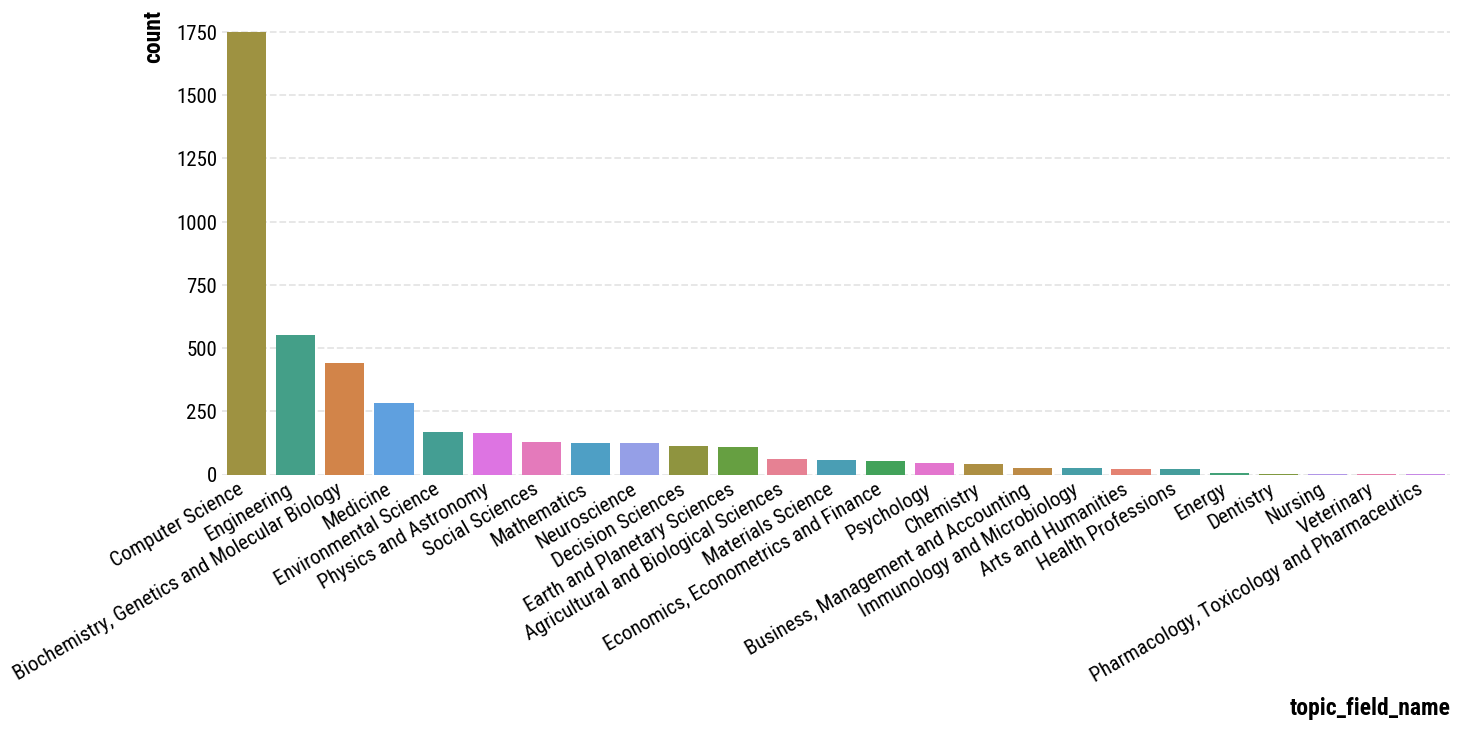

In [9]:
# Drop duplicates on document_id and topic_name
g = sns.catplot(
    hydrated_doc_topics.sort(
        "score",
        descending=True,
    ).unique(
        subset=["document_id", "topic_field_name"],
        keep="first",
    ).sort(
        "topic_field_name",
    ).group_by(
        "topic_field_name",
    ).agg(
        pl.col("document_id").count().alias("count"),
    ).sort(
        "count",
        descending=True,
    ),
    x="topic_field_name",
    y="count",
    kind="bar",
    hue="topic_field_name",
    hue_order=hydrated_doc_topics["topic_field_name"].unique().sort().to_list(),
    height=6,
    aspect=2.5,
)
g.figure.autofmt_xdate()

### Over Time

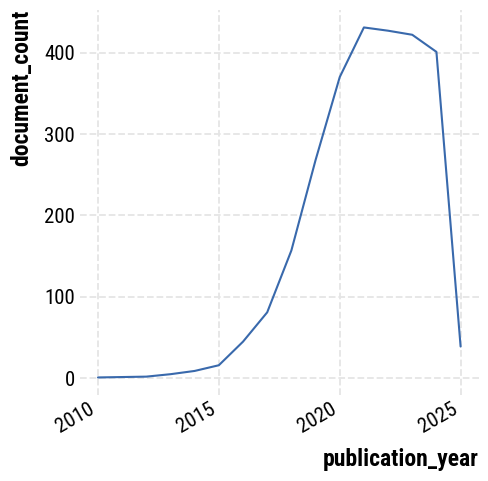

In [10]:
# Show the number of documents per topic domain over time (by year)
g = sns.relplot(
    hydrated_pairs.select(
        "document_id",
        "publication_date",
    ).with_columns(
        pl.col("publication_date").dt.year().alias("publication_year")
    ).group_by(
        "publication_year",
    ).agg(
        pl.col("document_id").count().alias("document_count"),
    ).sort(
        "publication_year",
    ).with_columns(
        pl.col("document_count").cum_sum().alias("document_sum"),
    ),
    x="publication_year",
    y="document_count",
    kind="line",
)
g.figure.autofmt_xdate()

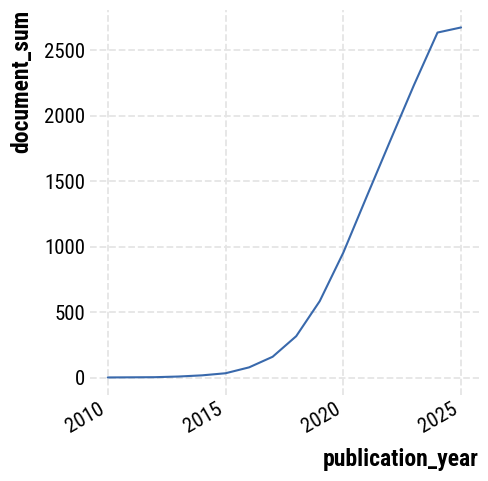

In [11]:
# Show the number of documents per topic domain over time (by year)
g = sns.relplot(
    hydrated_pairs.select(
        "document_id",
        "publication_date",
    ).with_columns(
        pl.col("publication_date").dt.year().alias("publication_year")
    ).group_by(
        "publication_year",
    ).agg(
        pl.col("document_id").count().alias("document_count"),
    ).sort(
        "publication_year",
    ).with_columns(
        pl.col("document_count").cum_sum().alias("document_sum"),
    ),
    x="publication_year",
    y="document_sum",
    kind="line",
)
g.figure.autofmt_xdate()

### Article Impact Metrics

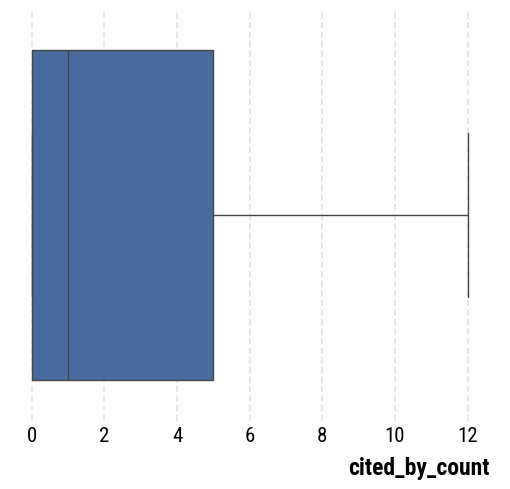

In [12]:
g = sns.catplot(
    hydrated_pairs.select(
        "document_id",
        "cited_by_count",
        "citation_normalized_percentile",
    ),
    x="cited_by_count",
    kind="box",
    showfliers=False,
)

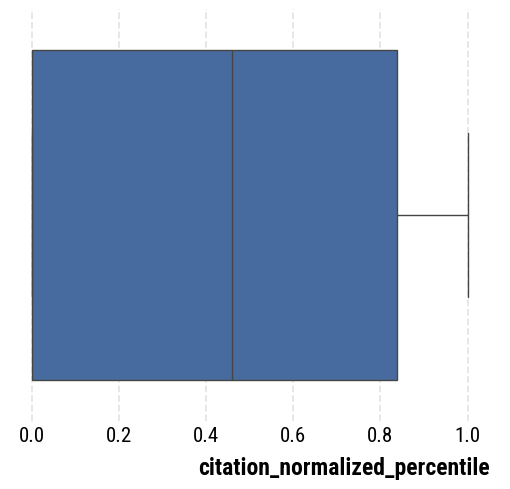

In [13]:
g = sns.catplot(
    hydrated_pairs.select(
        "document_id",
        "cited_by_count",
        "citation_normalized_percentile",
    ),
    x="citation_normalized_percentile",
    kind="box",
    showfliers=False,
)

### Document Type

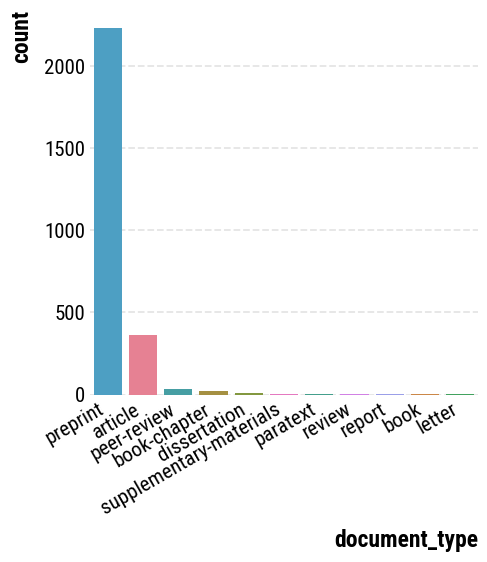

In [14]:
g = sns.catplot(
    hydrated_pairs.select(
        "document_id",
        "document_type",
    ).group_by(
        "document_type",
    ).agg(
        pl.col("document_id").count().alias("count"),
    ).sort(
        "count",
        descending=True,
    ),
    x="document_type",
    y="count",
    kind="bar",
    hue="document_type",
    hue_order=hydrated_docs["document_type"].unique().sort().to_list(),
)
g.figure.autofmt_xdate()

## Domain Breakouts

### Counts over Time

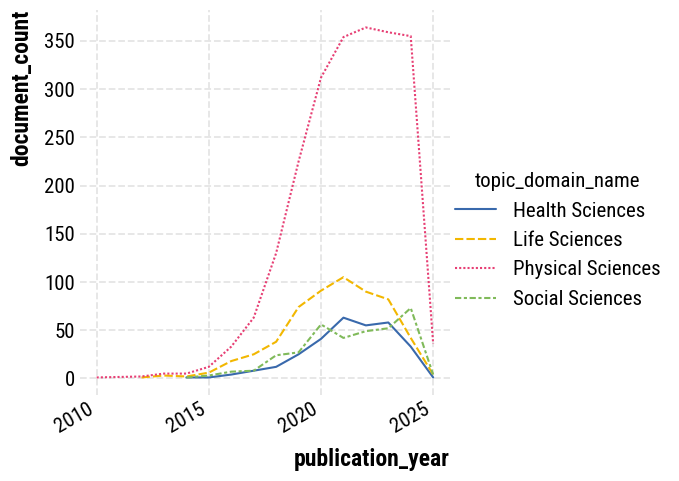

In [15]:
# Show the number of documents per topic domain over time (by year)
g = sns.relplot(
    hydrated_doc_topics.join(
        hydrated_pairs.select(
            "document_id",
            "publication_date",
        ),
        on="document_id",
        how="left",
    ).sort(
        "score",
        descending=True,
    ).unique(
        subset=["document_id", "topic_domain_name"],
        keep="first",
    ).with_columns(
        pl.col("publication_date").dt.year().alias("publication_year")
    ).group_by(
        "publication_year",
        "topic_domain_name",
    ).agg(
        pl.col("document_id").count().alias("document_count"),
    ).with_columns(
        pl.col("document_count").cum_sum().over("topic_domain_name", order_by="publication_year").alias("document_sum"),
    ),
    x="publication_year",
    y="document_count",
    hue="topic_domain_name",
    hue_order=hydrated_doc_topics["topic_domain_name"].unique().sort().to_list(),
    style="topic_domain_name",
    style_order=hydrated_doc_topics["topic_domain_name"].unique().sort().to_list(),
    kind="line",
)
g.figure.autofmt_xdate()

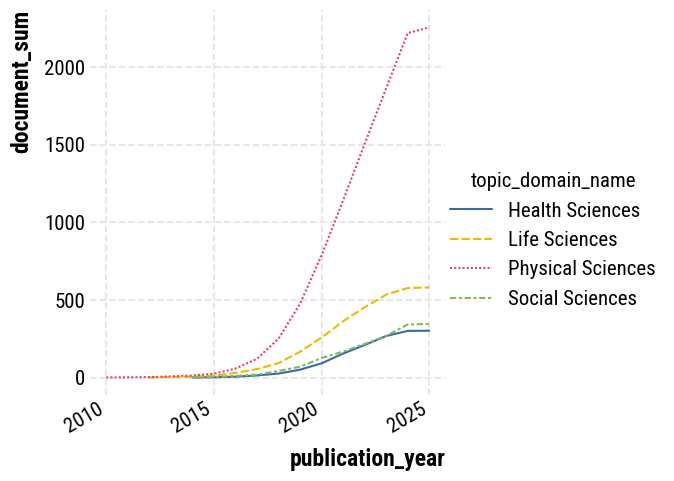

In [16]:
# Show the number of documents per topic domain over time (by year)
g = sns.relplot(
    hydrated_doc_topics.join(
        hydrated_pairs.select(
            "document_id",
            "publication_date",
        ),
        on="document_id",
        how="left",
    ).sort(
        "score",
        descending=True,
    ).unique(
        subset=["document_id", "topic_domain_name"],
        keep="first",
    ).with_columns(
        pl.col("publication_date").dt.year().alias("publication_year")
    ).group_by(
        "publication_year",
        "topic_domain_name",
    ).agg(
        pl.col("document_id").count().alias("document_count"),
    ).with_columns(
        pl.col("document_count").cum_sum().over("topic_domain_name", order_by="publication_year").alias("document_sum"),
    ),
    x="publication_year",
    y="document_sum",
    hue="topic_domain_name",
    hue_order=hydrated_doc_topics["topic_domain_name"].unique().sort().to_list(),
    style="topic_domain_name",
    style_order=hydrated_doc_topics["topic_domain_name"].unique().sort().to_list(),
    kind="line",
)
g.figure.autofmt_xdate()